### An outline of what I hope to accomplish

1. Load in digits data
2. Compute the nearest neighbors graph
3. Use Fiedler embedding to reduce dimension to 6
4. Compute local density.
5. Apply mapper code using the local density of the Fiedler embedding

In [1]:
import sys
import numpy
import itertools
from matplotlib import pyplot

In [2]:
%matplotlib inline

In [15]:
from sklearn.datasets import load_digits
from sklearn.neighbors import NearestNeighbors

## 1. Load digits

Step 1 is easy. The only work lies in turning an 8x8 grid into a 64 long vector. We use the `reshape` command.

In [4]:
dataset = load_digits()
n_samples = len(dataset.images)

In [5]:
digits = dataset.images.reshape((n_samples,-1))

In [6]:
digits.shape

(1797, 64)

## 2. Nearest neighbors graph

Bill's blog refers to the Nearest Neighbors graph. He neglects to mention a value for k. Let's go with k=2.

In [24]:
k = 2

In [25]:
neighbors = NearestNeighbors(n_neighbors = k).fit(digits)

In [28]:
neighbor_graph = neighbors.kneighbors_graph(digits).toarray()

## 3. Fiedler embedding

Now we run into trouble because I don't know what a Fiedler embedding is.

A perhaps related phrase I know is "Fiedler vector". This is a vector associated to a graph. Given a graph, compute the Laplacian matrix. Then compute and order the eigenvalues. The eigenvector corresponding to the second-smallest eigenvalue is the Fiedler vector. People find the concept useful and all the words meaningful.

I found this at Gitlab:

https://github.com/aneesha/Fiedler-Embeddings.git

They credit the notion of Fiedler embedding to Sandia Labs. From http://www.siam.org/meetings/sdm06/workproceed/Text%20Mining/hendrickson22.pdf

Given a graph:
1. Generate Laplacian matrix
2. Compute eigenvectors $u_2,\dots,u_{k+1}$, where eigenvectors are ordered by the corresponding eigenvalues, with $u_1$ corresponding to the smallest. Thus $u_2$ is the Fiedler vector.
3. Let $Q = [u_2,\dots, u_{k+1}]$.
4. Position vertex i at $\Delta^{1/2}Q^Te_i,$ where $e_i$ is the one-hot vector that is all zeroes except for a 1 in the $i$th position.

∆ is described as a "diagonal, non-negative matrix of coordinate scalings". I'll let you puzzle out what exactly that matrix should look like.

The fiedlerembedding code isn't good by most standards. Not a package one can install. Python2. And importing it just spits stuff to the screen. So I stuck it in a folder in my path, ran 2to3 on it, and added a `__name__=='__main'`

In [7]:
import fiedlerembedding

In [8]:
# This runs the example given
fiedlerembedding.main()

[[ -1.39860904e-08  -1.39860904e-08  -1.39860904e-08  -1.39860904e-08
   -1.39860904e-08  -1.39860904e-08  -1.39860904e-08  -1.39860904e-08
   -1.39860904e-08  -1.39860904e-08  -1.39860904e-08  -1.39860904e-08
   -1.39860904e-08  -1.39860904e-08  -1.39860904e-08  -1.39860904e-08
   -1.39860904e-08  -1.39860904e-08  -1.39860904e-08  -1.39860904e-08
   -1.39860904e-08]
 [ -1.08446518e-01  -1.17011359e-01  -1.05143939e-01  -1.05751595e-01
   -1.41384439e-01  -1.09768349e-01  -1.05143939e-01  -1.08863118e-01
    1.83082235e-01  -2.20175131e-02   2.47207340e-01   1.96657372e-01
   -9.51410743e-02  -1.22183101e-01  -1.14775133e-01  -1.13342837e-01
   -1.80893650e-01   2.95001263e-01   2.47337607e-01   2.30282111e-01
    1.50298635e-01]]
[ -1.39860904e-08  -1.05143939e-01]
[0 1]
computer
EPS


Now, the example of Fiedler embedding in the code starts with the document-term matrix, where the rows represent documents and the columns terms.

The description above is considered more general, and begins with a graph, which is representable by an adjacency matrix, where both rows and columns represent vertices.

An adjacency matrix is what we have. So we don't have to worry about the createLaplacian piece of the fiedler embedding code

In [29]:
# Choose the dimension of your embedding
k = 6

In [30]:
S = fiedlerembedding.fiedlerEmbeddedSpace(neighbor_graph,k)

/Users/chrisn/mad-science/fiedlerembedding.py:59: RuntimeWarning: invalid value encountered in sqrt
  eval_k = diag(eval_k,0)**0.5


I got a runtime warning about null values and square roots. I chose to ignore it.

In [31]:
S.shape

(6, 1797)

That shape is really the transpose of what I expected, but let's go with it.

In [37]:
S

array([[             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [             nan,              nan,              nan, ...,
                     nan,              nan,              nan],
       [ -3.49735928e-05,   6.51846362e-06,   1.08060906e-05, ...,
          1.57257983e-04,   3.20151435e-06,  -1.82793162e-04],
       [  2.83771387e-03,   3.69696885e-03,  -1.10151360e-03, ...,
         -1.52625256e-04,   1.81942919e-03,   2.67960758e-03],
       [ -1.07619904e-03,   2.64255229e-04,  -3.91267506e-04, ...,
          3.54599514e-04,  -9.80909371e-04,   1.74600795e-03]])

## 3. Local density

To each of our 1797 images, we associate a local density. The number of images in a ball of fixed radius around our given image.

What radius to pick?

And Bill's blog suggested computing local density not on the given 64-dimensional space, but rather on a 6-dimensional space. The above was supposed to deal with that, but I'm not overly satisfied.

Pressing forward anyway, we define a radius.

In [32]:
mymatrix = digits # Perhaps change to the Fiedler embedding if that works.r4fr

In [33]:
distances = numpy.zeros((n_samples,n_samples))
for i,j in itertools.combinations(range(n_samples),2):
    distances[i,j] = numpy.linalg.norm(mymatrix[i]-mymatrix[j])

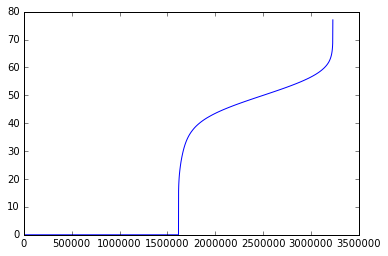

In [34]:
flat = distances.flatten()
flat.sort()
pyplot.plot(flat);

With any luck, the picture above suggests a good radius to call close.

In [35]:
r = 20

In [36]:
# Then this numpy array represents your local densities.
(distances < 20).sum(axis=1)

array([  44,    6,    4, ..., 1795, 1796, 1797])

## 4. Next comes the mapper code

But first we should really get the above working.